# Kaggle: Titanic Challenge
## Coded by Daniel Wilcox

This is a notebook showing the process in predicting the survivors of the Titanic.

In [1]:
import os
import pickle
import glob

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import randint, reciprocal, expon, uniform

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone

#Fills in values to empty data locations
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Creating custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer




from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier



from sklearn.ensemble import VotingClassifier


In [2]:
#The Location to save the dataset
TITANIC_PATH = "datasets/titanic"
TITANIC_URL = "https://github.com/Daniel-Wilcox/ADA-874-2019/blob/master/datasets/titanic/"
train_name = "train.csv" 
test_name = "test.csv" 


#The Location to save the models
PICKLE_PATH = "PickleModels/Titanic"

In [3]:
#Pickle functions

#Saving and storing the model
def save_pickle(model_name, model, pic_path=PICKLE_PATH):
    print("Saving model...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
        
    f = open(model_name, "wb")
    pickle.dump(model, f)
    f.close()
    
    os.chdir(cwd)
    print("Saved "+model_name+" successfully!\n")
    return None
    
    
#Retrieving and loading the model
def load_pickle(model_name, pic_path=PICKLE_PATH):
    print("Loading "+model_name+" from Pickle file...")
    
    cwd = os.getcwd()
    os.chdir(cwd+"/"+pic_path)
    
    f = open(model_name, "rb")
    p = pickle.load(f)
    f.close()
    
    os.chdir(cwd)
    print(model_name+" successfully loaded!\n")
    return p

#Check whether the pickel exists
def pickle_exist(model_name, pic_path=PICKLE_PATH):
    #check if pickle file exists
    print("Checking if pickle directory exists...")
    if not os.path.isdir(pic_path):
        os.makedirs(pic_path)
        print("Directory does NOT exists")
        print("Creating directory")
    
    else: 
        print("Directory exists")
        
    if os.path.isfile(pic_path+"/"+model_name):
        print("Pickle file does exists...")
        return True
    else:
        print("Pickle file does NOT exists...")
        return False

In [4]:
def load_Titanic_data(file_name, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    return pd.read_csv(csv_path)
        
    
def get_Titanic_data(file_name, titanic_url=TITANIC_URL, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, file_name)
    
    print("Checking if directory exists...")
    if not os.path.isdir(titanic_path):
        os.makedirs(titanic_path)
        print("Creating directory")
    
    else: 
        print("Directory exists") 
            
        if os.path.isfile(csv_path):
            print(file_name + " file does exists...")
            print("extracting " + file_name)
            
            titanic = load_Titanic_data(file_name)
            print("\nSuccess!")
            return titanic
        
        else:
            print(file_name + " file doesn't exists...")
            print("Download .csv from Kaggle!")

            return None
                   

In [5]:
Train = get_Titanic_data(train_name)
Test = get_Titanic_data(test_name)


Checking if directory exists...
Directory exists
train.csv file does exists...
extracting train.csv

Success!
Checking if directory exists...
Directory exists
test.csv file does exists...
extracting test.csv

Success!


In [6]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
Train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Variable - Definition                              - Key
1. survival - Survival                                - 0/1 = No/Yes
2. pclass   - Ticket class                            - 1,2,3 = 1st, 2nd, 3rd class
3. sex      - Sex                                     - male, female
4. Age      - Age in years                            - ...
5. sibsp    - # of siblings/spouses on the Titanic    - ...
6. parch    - # of parents/children on the Titanic    - ...
7. ticket   - Ticket number                           - ...
8. fare     - Passenger fare                          - ...
9. cabin    - Cabin number                            - ...
10. embarked - Port of Embarkation                     - C = Cherbourg, Q = Queenstown, S = Southampton


In [8]:
#It can be seen that there are some features that have NaN values.

In [9]:
Train.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [10]:
sur = Train["Survived"].value_counts() / len(Train)
print("{:.2f}% Survived\n{:.2f}% Died".format(100*sur[1],100*sur[0]))

38.38% Survived
61.62% Died


In [11]:
#Correlation matrix (numeric features)
corr_matrix = Train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

In [12]:
#check the different features:

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


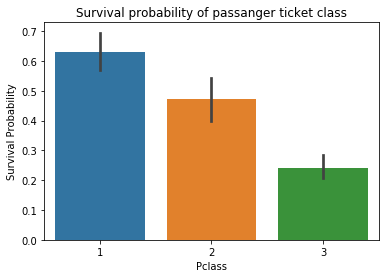

In [13]:
#Pclass

fig = sns.barplot(x="Pclass",y="Survived",data=Train)
fig = fig.set(xlabel="Pclass", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger ticket class")


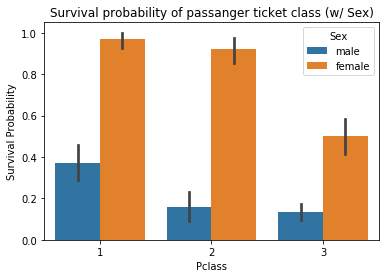

In [14]:
#Pclass w/ Sex

fig = sns.barplot(x="Pclass",y="Survived", hue="Sex", data=Train)
fig = fig.set(xlabel="Pclass", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger ticket class (w/ Sex)")


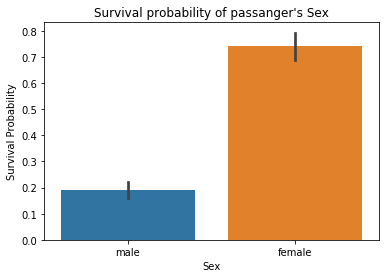

In [15]:
#Sex

fig = sns.barplot(x="Sex",y="Survived",data=Train)
fig = fig.set(xlabel="Sex", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger's Sex")


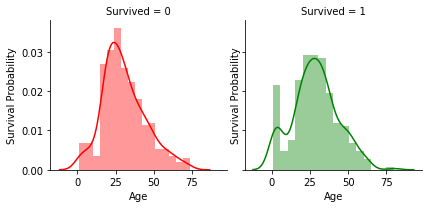

In [16]:
#Age

d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(Train, col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "Age")   

fig = fig.set(xlabel="Age", ylabel="Survival Probability")

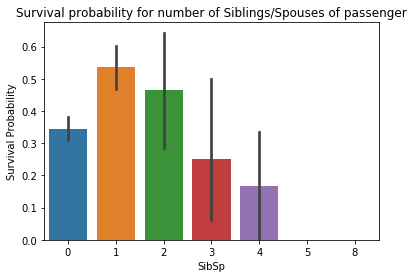

In [17]:
#SibSp

fig = sns.barplot(x="SibSp",y="Survived",data=Train)
fig = fig.set(xlabel="SibSp", ylabel="Survival Probability")
fig = plt.title("Survival probability for number of Siblings/Spouses of passenger")


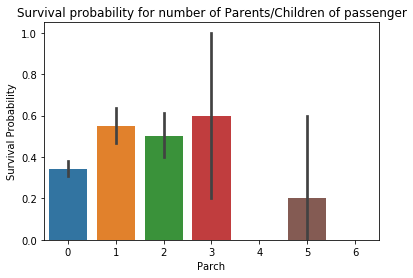

In [18]:
#Parch

fig = sns.barplot(x="Parch",y="Survived",data=Train)
fig = fig.set(xlabel="Parch", ylabel="Survival Probability")
fig = plt.title("Survival probability for number of Parents/Children of passenger")


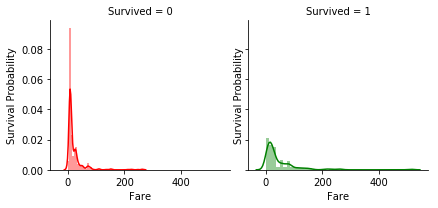

In [19]:
#Fare

d = {'color': ['r', 'g']}   
fig = sns.FacetGrid(Train, col='Survived',  hue_kws=d, hue='Survived')
fig = fig.map(sns.distplot, "Fare")   

fig = fig.set(xlabel="Fare", ylabel="Survival Probability")

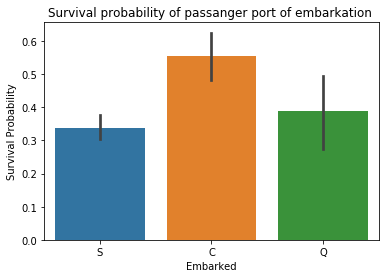

In [20]:
#Embarked

fig = sns.barplot(x="Embarked",y="Survived",data=Train)
fig = fig.set(xlabel="Embarked", ylabel="Survival Probability")
fig = plt.title("Survival probability of passanger port of embarkation ")


In [21]:
#feature eng:

#tr = Train.drop("Survived", axis=1)
#Full_set = pd.concat(objs=[tr, Test], axis=0).reset_index(drop=True)
Full_set = pd.concat(objs=[Train, Test], axis=0).reset_index(drop=True)


#Name: f_name, honorifics. sur_name
honorifics = [i.split(",")[1].split(".")[0].strip() for i in Full_set["Name"]]
Full_set["Title"] = pd.Series(honorifics)
Full_set.Title.unique()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

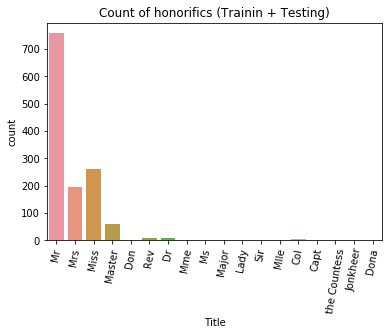

In [22]:
fig = sns.countplot(x="Title",data=Full_set)
#fig = fig.set(xlabel="Title", ylabel="Survival Probability")
fig = plt.setp(fig.get_xticklabels(), rotation=80) 
fig = plt.title("Count of honorifics (Trainin + Testing)")


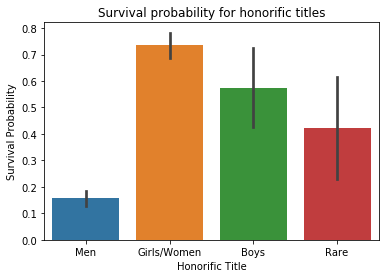

In [23]:
Full_set["Title"] = Full_set["Title"].replace(['Don', 
        'Rev', 'Dr', 'Mme', 'Major', 'Lady', 
        'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
        'Jonkheer', 'Dona'], 'Rare')

Full_set["Title"] = Full_set["Title"].replace(['Mrs',
        'Miss', 'Ms'], 'Girls/Women')

Full_set["Title"] = Full_set["Title"].replace(['Master'],
        'Boys')

Full_set["Title"] = Full_set["Title"].replace(['Mr'],
        'Men')
fig = sns.barplot(x="Title",y="Survived",data=Full_set)
fig = fig.set(xlabel="Honorific Title", ylabel="Survival Probability")
fig = plt.title("Survival probability for honorific titles")

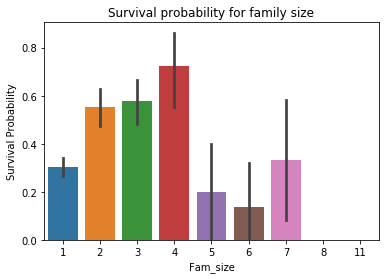

In [24]:
#Family size

Full_set["Fam_size"] = Full_set["SibSp"] + Full_set["Parch"] + 1

fig = sns.barplot(x="Fam_size",y="Survived", data=Full_set)
fig = fig.set(xlabel="Fam_size", ylabel="Survival Probability")
fig = plt.title("Survival probability for family size")

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


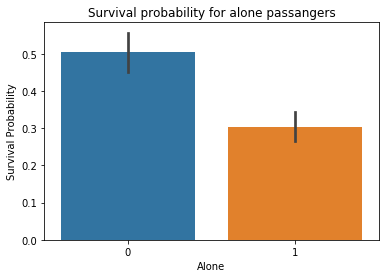

In [25]:
#Alone
Full_set["Alone"] = 1
Full_set["Alone"].loc[Full_set['Fam_size'] > 1] = 0

fig = sns.barplot(x="Alone",y="Survived", data=Full_set)
fig = fig.set(xlabel="Alone", ylabel="Survival Probability")
fig = plt.title("Survival probability for alone passangers")

In [26]:
Train.shape

(891, 12)

In [27]:
#Separtate labels from features
y_train = Train["Survived"].copy()
X_tr = Train.drop("Survived", axis=1)
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


In [28]:
#Remove Features (survived is already removed)
list_drop = ['Name', 'Ticket', 'Cabin', 'Pclass']
list_excl = ['Ticket', 'Cabin'] 

add_fam_feat = True
add_alone = True 
add_title = True
    
Dropped = X_tr[list(set(X_tr.columns) - set(list_drop))]

#Numeric Features
list_num = Dropped.select_dtypes(include = ["number"]).columns

#Catagorical Features (to be transformed into OHE)
list_cat = Dropped.select_dtypes(include = ["object"]).columns

list_add = X_tr[list(set(X_tr.columns) - set(list_excl))].columns


if add_fam_feat:
    list_num = list_num.insert(len(list_num)+ 1,'Fam_size')
    
if add_alone:
    list_num = list_num.insert(len(list_num)+1,'Alone')    
    
if add_title:
    list_cat = list_cat.insert(len(list_num)+1,'Title')
    
list_cat = list_cat.insert(len(list_num)+1,'Pclass')

print('list_num: {}'.format(list(list_num)))
print('list_cat: {}'.format(list(list_cat)))
print('list_add: {}'.format(list(list_add)))

list_num: ['SibSp', 'Parch', 'Age', 'PassengerId', 'Fare', 'Fam_size', 'Alone']
list_cat: ['Sex', 'Embarked', 'Title', 'Pclass']
list_add: ['Pclass', 'SibSp', 'Sex', 'Embarked', 'Parch', 'Age', 'PassengerId', 'Name', 'Fare']


In [29]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return(self)
    
    def transform(self, X):
        return X[self.feature_names].values
    
    
    
class add_features(BaseEstimator, TransformerMixin):
    def __init__(self, added_feat, add_fam=True, 
                 add_alone=True, add_title=True):
        
        self.added_feat = added_feat
        self.add_fam = add_fam
        self.add_alone = add_alone
        self.add_title = add_title
   

    def fit(self, X, y=None):
        return(self)

    
    def transform(self, X):  
        df = X[self.added_feat]
        
        if self.add_fam:
            df["Fam_size"] = df.loc[:,"SibSp"] + df.loc[:,"Parch"] + 1
            
        if self.add_alone:
            df["Alone"] = 0
            df["Alone"].loc[(df["SibSp"]==0) & 
                           (df["Parch"]==0)] = 1
            
        if self.add_title:
            honorifics = [i.split(",")[1].split(".")[0].
                          strip() for i in df["Name"]]
            
            df["Title"] = pd.Series(honorifics)
            
            df["Title"] = df.loc[:,"Title"].replace(
                ['Don', 'Rev', 'Dr', 'Mme', 'Major', 
                 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                 'the Countess', 'Jonkheer', 'Dona'],
                 'Rare')

            df["Title"] = df.loc[:,"Title"].replace(
                ['Mrs','Miss','Ms'], 'Girls/Women')

            df["Title"] = df.loc[:,"Title"].replace(
                ['Master'], 'Boys')

            df["Title"] = df.loc[:,"Title"].replace(
                ['Mr'], 'Men') 
            
            df.drop(labels=["Name"], axis = 1, 
                   inplace = True)

        return df 

In [30]:
#Add Features
add_pipeline = Pipeline([
    ('add_feat', add_features(list_add))
])

#Numeric Transformations
num_pipeline = Pipeline([
    ('selector', Selector(list_num)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

#Catagorical Transformations
cat_pipeline = Pipeline([
    ('selector', Selector(list_cat)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [31]:
a = add_pipeline.fit_transform(X_tr)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
print('Transformed Dataframe: {}'.format(list(a.columns)))

Transformed Dataframe: ['Pclass', 'SibSp', 'Sex', 'Embarked', 'Parch', 'Age', 'PassengerId', 'Fare', 'Fam_size', 'Alone', 'Title']


In [33]:
a.head(5)

,Pclass,SibSp,Sex,Embarked,Parch,Age,PassengerId,Fare,Fam_size,Alone,Title
0,3,1,male,S,0,22.0,1,7.2500,2,0,Men
1,1,1,female,C,0,38.0,2,71.2833,2,0,Girls/Women
2,3,0,female,S,0,26.0,3,7.9250,1,1,Girls/Women
3,1,1,female,S,0,35.0,4,53.1000,2,0,Girls/Women
4,3,0,male,S,0,35.0,5,8.0500,1,1,Men


In [34]:
perpare_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

full_pipe = Pipeline([
    ("add_pipeline", add_pipeline),
    ("prep_pipeline", perpare_pipeline)
])

X_train = full_pipe.fit_transform(X_tr)
X_train.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(891, 19)

In [35]:
#Scaled Test Set for predictions:
X_test = full_pipe.fit_transform(Test)
X_test.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(418, 19)

In [51]:
#To create new model if pickle already even if pickle exists; load_pkl = False
load_pkl = False

cv_split=StratifiedKFold(n_splits=10)
cv_split

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [52]:
def model_cross_val(clf, name_clf, lp=load_pickle):
    if pickle_exist(str(name_clf)) and (lp==True):
        ml_clf = load_pickle(str(name_clf))
    else:
        ml_clf = clf
        ml_clf.fit(X_train, y_train)
        save_pickle(str(name_clf), ml_clf)
    cvs =  cross_val_score(ml_clf, X_train, y_train, cv=cv_split, scoring="accuracy") 
    return  np.mean(cvs)


In [53]:
clf_options = [          
    LinearSVC(),
    SVC(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SGDClassifier(),
    KNeighborsClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(),
                       learning_rate=0.1),
    ExtraTreesClassifier(),
    GradientBoostingClassifier()
] 
 
compare_col = ['Clf Name', 'Clf Parameters', 'Clf Mean Accuracy'] 
clf_compare = pd.DataFrame(columns = compare_col)
                 
row=0
          
for clf in clf_options: 
    clf_name = clf.__class__.__name__
                    
    clf_compare.loc[row, 'Clf Name'] = clf_name
    clf_compare.loc[row, 'Clf Parameters'] = str(clf.get_params()) 
    cvs = model_cross_val(clf, clf_name)
    
    clf_compare.loc[row, 'Clf Mean Accuracy'] = cvs
    
    row +=1

               

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LinearSVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved SVC successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved LogisticRegression successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved DecisionTreeClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved RandomForestClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved SGDClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved KNeighborsClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved AdaBoostClassifier successfully!

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved ExtraTreesClassifier successfully!



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

Checking if pickle directory exists...
Directory exists
Pickle file does exists...
Saving model...
Saved GradientBoostingClassifier successfully!



In [54]:
clf_compare.sort_values(by = 'Clf Mean Accuracy', ascending = False, inplace = True)
clf_compare

,Clf Name,Clf Parameters,Clf Mean Accuracy
1,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.83278
0,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.829397
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.82499
2,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.819322
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.812693
9,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.81157
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.802505
5,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.747497
7,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.734053
3,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.730733


In [55]:
#Parameters of classifiers (Random Search):

#Linear SVC
lin_svc_rs = {
    'loss' : ['hinge','squared_hinge'],
    'C' : reciprocal(0.01, 1000)
}


#SVC
svc_rs = {
    'C' : reciprocal(0.01, 1000),
    'kernel' : ['linear', 'rbf'],
    'gamma' : reciprocal(0.01, 10000)
}


#Logistic Regression
log_reg_rs = {
    'penalty' : ['l1', 'l2'],
    'C' : reciprocal(0.01, 1000) 
}


#Decision Tree Classifier
tree_rs = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : randint(1, 5),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_features' : randint(1, 15)
}


#Random Forest Classifier
forest_rs = {
    'n_estimators' : randint(10, 200),
    'criterion' : ['gini', 'entropy'],
    'max_depth' : randint(1, 5),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_features' : randint(1, 15)
}


#SGDClassifier
SGDC_rs = {
    'loss' : ['hinge','squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2'],
    'alpha': reciprocal(0.1, 10000), 
    'warm_start' : [True, False]
}
    

#K-Neighbors Classifier
k_neigh_rs = {
    'n_neighbors': randint(3, 15),
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : randint(2, 100),
    'p' : randint(1, 2)
}


#AdaBoost Classifier
ada_rs = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'n_estimators' : randint(1, 50),
    'learning_rate' : reciprocal(0.6, 10000),
    'algorithm' : ['SAMME', 'SAMME.R']
    
}

#Extra Trees Classifier
extra_tree_rs = {
    'n_estimators' : randint(10, 500),
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_features' : randint(1, 15)    
    
}

#Gradient Boosting Classifier
grad_boost_rs = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : reciprocal(0.6, 10000),
    'n_estimators' : randint(10, 500),
    'min_samples_split' : randint(2, 15),
    'min_samples_leaf' : randint(1, 15),
    'max_depth': randint(3, 15),
    'max_features' : randint(1, 15)
    
}       


param_option_rs = [
    lin_svc_rs,
    svc_rs,
    log_reg_rs,
    tree_rs,
    forest_rs,
    SGDC_rs,
    k_neigh_rs,
    ada_rs,
    extra_tree_rs,
    grad_boost_rs
]


In [56]:
#-------------------------------------------------------------------------------
def model_rand_gs(clf, name_clf, clf_param, lp=load_pickle): 

    rand_clf = RandomizedSearchCV(clf, param_distributions=clf_param, cv=cv_split, 
                          verbose=2, n_jobs=-1, n_iter=300, scoring='accuracy')
    
    rand_clf.fit(X_train, y_train)
    
    best_est = rand_clf.best_estimator_
    best_sco = rand_clf.best_score_ 
    
    text_check = os.path.isfile(PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt")
    
    if pickle_exist("best_rs_"+str(name_clf)) and text_check and (lp==True):
        #load current best score
        prev_best_score = max(np.loadtxt(
            (PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt"), dtype=float))

        if best_sco > prev_best_score:
            temp = [best_sco, best_sco]
            np.savetxt(
                PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", temp, fmt='%f')
            save_pickle("best_rs_"+str(name_clf), best_est)
        else:
            #load in better parameters
            best_sco = max(np.loadtxt(
                PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", dtype=float))
            best_est = load_pickle("best_rs_"+str(name_clf))
    else:
        #make pickles if dont exist
        temp = [best_sco, best_sco]
        np.savetxt(
            PICKLE_PATH+"/best_score_rs_"+str(name_clf)+".txt", temp, fmt='%f')
        save_pickle("best_rs_"+str(name_clf), best_est)


In [57]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Accuracy Score'] 
best_compare_rs = pd.DataFrame(columns = best_col)
          
          
row=0

for clf, param in zip(clf_options, param_option_rs): 
    
    clf_name = clf.__class__.__name__
    best_compare_rs.loc[row, 'Clf Name'] = clf_name
    
    print("{}: {}".format(row, clf_name))
    
    
    #model_grid(clf, clf_name, param)
    model_rand_gs(clf, clf_name, param)
   
    
    best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    best_clf = load_pickle("best_rs_"+str(clf_name))
    
    print("{}: {}\n".format(clf_name, best_clf.get_params))
        
    best_compare_rs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_compare_rs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    row +=1
                    

0: LinearSVC
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s


KeyboardInterrupt: 

In [ ]:
#Random Grid-search
best_compare_rs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)
best_compare_rs

In [ ]:
#Parameters of classifiers (Grid Search):

#Linear SVC
lin_svc_param = {
    'loss' : ['hinge','squared_hinge'],
    'C' : [1, 2, 5, 10]
}

#SVC
svc_param = {
    'C' : [1, 2, 5, 10],
    'kernel' : ['linear', 'rbf'],
    'gamma' : [ 0.001, 0.01, 0.1, 1]
}

#Logistic Regression
log_reg_param = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 2, 5, 10]
}

#Decision Tree Classifier
tree_param = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : [1, 2, 3, 5],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [1, 5, 10]
}

#Random Forest Classifier
forest_param = {
    'n_estimators' : [10, 50, 100],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [1, 2, 5],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 3, 10],
    'max_features' : [1, 5, 10]
}

#SGDClassifier
SGDC_param = {
    'loss' : ['hinge','squared_hinge', 'perceptron'],
    'penalty' : ['l1', 'l2'],
    'alpha' : [0.001, 0.01, 0.1, 1],
    'warm_start' : [True, False]
}

#K-Neighbors Classifier
k_neigh_param = {
    'n_neighbors': [3, 4, 5, 10],
    'weights' : ['uniform','distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [2, 10, 50, 100],
    'p' : [1, 2]
}

#AdaBoost Classifier
ada_param = {
    'base_estimator__criterion' : ['gini', 'entropy'],
    'base_estimator__splitter' : ['best', 'random'],
    'n_estimators' : [1, 2, 5, 10, 50],
    'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
    'algorithm' : ['SAMME', 'SAMME.R']
    
}

#Extra Trees Classifier
extra_tree_param = {
    'n_estimators' : [100, 200, 300, 500],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 5,10],
    'max_features' : [1, 5, 10]    
    
}

#Gradient Boosting Classifier
grad_boost_param = {
    'loss' : ['deviance', 'exponential'],
    'learning_rate' : [0.01, 0.1, 1],
    'n_estimators' : [100, 200],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 10, 100],
    'max_depth': [3, 5, 10],
    'max_features': [0.1, 0.3]
    
}              

               
                
param_option_gs = [
    lin_svc_param,
    svc_param,
    log_reg_param,
    tree_param,
    forest_param,
    SGDC_param,
    k_neigh_param,
    ada_param,
    extra_tree_param,
    grad_boost_param
]

In [ ]:

def model_grid(clf, name_clf, clf_param, lp=load_pickle): 

    gs_clf = GridSearchCV(clf, param_grid=clf_param, cv=cv_split, 
                          verbose=2, n_jobs=-1, scoring='accuracy')
    
    gs_clf.fit(X_train, y_train)
    
    best_est = gs_clf.best_estimator_
    best_sco = gs_clf.best_score_ 
    
    text_check = os.path.isfile(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt")
    
    if pickle_exist("best_gs_"+str(name_clf)) and text_check and (lp==True):
        #load current best score
        prev_best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt"), dtype=float))

        if best_sco > prev_best_score:
            temp = [best_sco, best_sco]
            np.savetxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", temp, fmt='%f')
            save_pickle("best_gs_"+str(name_clf), best_est)
        else:
            #load in better parameters
            best_sco = max(np.loadtxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", dtype=float))
            best_est = load_pickle("best_gs_"+str(name_clf))
    else:
        #make pickles if dont exist
        temp = [best_sco, best_sco]
        np.savetxt(PICKLE_PATH+"/best_score_gs_"+str(name_clf)+".txt", temp, fmt='%f')
        save_pickle("best_gs_"+str(name_clf), best_est)

    
    

In [ ]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Accuracy Score'] 
best_compare_gs = pd.DataFrame(columns = best_col)
          
          
row=0

for clf, param in zip(clf_options, param_option_gs): 

    
    clf_name = clf.__class__.__name__
    best_compare_rs.loc[row, 'Clf Name'] = clf_name
    
    print("{}: {}".format(row, clf_name))
    
    model_grid(clf, clf_name, param)
    
    best_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    best_clf = load_pickle("best_gs_"+str(clf_name))
    
    best_compare_gs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_compare_gs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    row +=1

In [ ]:
#After Gridseach
best_compare_gs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)
best_compare_gs

In [58]:
def load_best_clf(clf):
    clf_name = clf.__class__.__name__
    
    gs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    rs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    
    if gs_score > rs_score:
        return load_pickle("best_gs_"+str(clf_name))
    else:
        return load_pickle("best_rs_"+str(clf_name))

    
    
def load_best_score(clf):
    clf_name = clf.__class__.__name__
    
    gs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_gs_"+str(clf_name)+".txt"), dtype=float))
    rs_score = max(np.loadtxt((PICKLE_PATH+"/best_score_rs_"+str(clf_name)+".txt"), dtype=float))
    
    if gs_score > rs_score:
        return gs_score
    else:
        return rs_score

In [59]:
best_col = ['Clf Name', 'Best Clf Parameters', 'Best Clf Accuracy Score'] 
best_rs_or_gs = pd.DataFrame(columns = best_col)
row=0

for clf in clf_options:
    clf_name = clf.__class__.__name__
    best_rs_or_gs.loc[row, 'Clf Name'] = clf_name
    
    best_clf  = load_best_clf(clf)
    best_score = load_best_score(clf)
    
    best_rs_or_gs.loc[row, 'Best Clf Parameters'] = str(best_clf.get_params())
    best_rs_or_gs.loc[row, 'Best Clf Accuracy Score'] = str(best_score)
    
    row +=1
    
best_rs_or_gs.sort_values(by = 'Best Clf Accuracy Score', ascending = False, inplace = True)
best_rs_or_gs    

Loading best_rs_LinearSVC from Pickle file...
best_rs_LinearSVC successfully loaded!

Loading best_rs_SVC from Pickle file...
best_rs_SVC successfully loaded!

Loading best_rs_LogisticRegression from Pickle file...
best_rs_LogisticRegression successfully loaded!

Loading best_rs_DecisionTreeClassifier from Pickle file...
best_rs_DecisionTreeClassifier successfully loaded!

Loading best_gs_RandomForestClassifier from Pickle file...
best_gs_RandomForestClassifier successfully loaded!

Loading best_gs_SGDClassifier from Pickle file...
best_gs_SGDClassifier successfully loaded!

Loading best_rs_KNeighborsClassifier from Pickle file...
best_rs_KNeighborsClassifier successfully loaded!

Loading best_gs_AdaBoostClassifier from Pickle file...
best_gs_AdaBoostClassifier successfully loaded!

Loading best_rs_ExtraTreesClassifier from Pickle file...
best_rs_ExtraTreesClassifier successfully loaded!

Loading best_gs_GradientBoostingClassifier from Pickle file...
best_gs_GradientBoostingClassifier 

,Clf Name,Best Clf Parameters,Best Clf Accuracy Score
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.842873
9,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.840629
8,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.837262
1,SVC,"{'C': 8.492752161953996, 'cache_size': 200, 'c...",0.836139
0,LinearSVC,"{'C': 7.2682009313500435, 'class_weight': None...",0.832772
3,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.828283
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 2, 'metric'...",0.823793
2,LogisticRegression,"{'C': 0.37939817243785123, 'class_weight': Non...",0.822671
5,SGDClassifier,"{'alpha': 0.01, 'average': False, 'class_weigh...",0.819304
7,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.789001


In [60]:
#Feature importance:

#NOTE: add val set and retrain


In [104]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, ver_index in split.split(Train, Train["Survived"]):
    Train_strat = Train.loc[train_index]
    Ver_strat = Train.loc[ver_index]

print("Training set: {} entries, Verificaiton set: {} entries".format(len(Train_strat),len(Ver_strat)))

Training set: 712 entries, Verificaiton set: 179 entries


In [105]:
y_training = Train_strat["Survived"].copy()
X_tr = Train_strat.drop("Survived", axis=1)
X_training = full_pipe.fit_transform(X_tr)

y_verification = Ver_strat["Survived"].copy()
X_ver = Ver_strat.drop("Survived", axis=1)
X_verification = full_pipe.fit_transform(X_ver)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/

In [109]:
lin_svc = load_best_clf(clf_options[0])
svc = load_best_clf(clf_options[1])
log_reg = load_best_clf(clf_options[2])
tree = load_best_clf(clf_options[3])
forest = load_best_clf(clf_options[4])
SGDC = load_best_clf(clf_options[5])
knn = load_best_clf(clf_options[6])
ada = load_best_clf(clf_options[7])
etree = load_best_clf(clf_options[8])
gradb = load_best_clf(clf_options[9]) 

svc.set_params(probability=True)

    
est = [('lin_svc', lin_svc), ('svc', svc), ('log_reg', log_reg),
       ('forest', forest), ('SGDC', SGDC), ('tree', tree),
       ('ada', ada), ('etree', etree), ('knn', knn),
       ('gradb', gradb)]



vote_clf = VotingClassifier(estimators=est, voting='hard')

vote_clf.fit(X_training, y_training)


Loading best_rs_LinearSVC from Pickle file...
best_rs_LinearSVC successfully loaded!

Loading best_rs_SVC from Pickle file...
best_rs_SVC successfully loaded!

Loading best_rs_LogisticRegression from Pickle file...
best_rs_LogisticRegression successfully loaded!

Loading best_rs_DecisionTreeClassifier from Pickle file...
best_rs_DecisionTreeClassifier successfully loaded!

Loading best_gs_RandomForestClassifier from Pickle file...
best_gs_RandomForestClassifier successfully loaded!

Loading best_gs_SGDClassifier from Pickle file...
best_gs_SGDClassifier successfully loaded!

Loading best_rs_KNeighborsClassifier from Pickle file...
best_rs_KNeighborsClassifier successfully loaded!

Loading best_gs_AdaBoostClassifier from Pickle file...
best_gs_AdaBoostClassifier successfully loaded!

Loading best_rs_ExtraTreesClassifier from Pickle file...
best_rs_ExtraTreesClassifier successfully loaded!

Loading best_gs_GradientBoostingClassifier from Pickle file...
best_gs_GradientBoostingClassifier 

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


VotingClassifier(estimators=[('lin_svc', LinearSVC(C=7.2682009313500435, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)), ('svc', SVC(C=8.492752161953996, cache_size=...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [111]:
for clf in (lin_svc, svc, log_reg, forest, 
            SGDC, tree, ada, etree, knn, 
            gradb, vote_clf):

    clf.fit(X_training, y_training)
    y_pred = clf.predict(X_verification)
    
    name = clf.__class__.__name__
    score = accuracy_score(y_verification, y_pred)
    
    print("{}: {:.2f}%".format(name, 100*score))

LinearSVC: 81.01%
SVC: 82.68%
LogisticRegression: 81.56%
RandomForestClassifier: 77.65%


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


ValueError: Provided coef_init does not match dataset.

In [108]:
#fit to whole dataset
vote_clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


VotingClassifier(estimators=[('lin_svc', LinearSVC(C=7.2682009313500435, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)), ('svc', SVC(C=8.492752161953996, cache_size=...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [101]:
def make_csv(csv_name, save_loc=TITANIC_PATH):
    curr_path = os.getcwd()
    save_path = os.path.join(curr_path, save_loc)
    os.chdir(save_path)
    
    max_i = 0
    
    len_name = len(csv_name)
           
    for file in glob.glob(csv_name+'*.csv'):
        
        file_name = file[:len(file)-4]
        file_ver = file_name[len_name:]
        
        if int(file_ver) > max_i:
            max_i = int(file_ver)
        
    new_ver = csv_name+str(max_i+1)+'.csv'
        
        
        
    os.chdir(curr_path)
    
    return os.path.join(save_path, new_ver)
    

In [102]:
PassengerId = Test['PassengerId']

Survived_pred = vote_clf.predict(X_test) 


Submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': Survived_pred })

name = "Submission"
file_name = make_csv(name)

Submission.to_csv(file_name, index=False)


In [103]:
Submission.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
